In [ ]:
%pip install scikit-build
%pip install pyikarus  --no-build-isolation --verbose --upgrade
#!pip install pyzmq==19.0.2 --force-reinstall
#!pip install traitlets==4.3.3 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 410.4 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Using pip 23.0.1 from /dune/dune-common/build-cmake/dune-env/lib/python3.10/site-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 2.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (pyproject.toml) ...   Running command Preparing metadata (pyproject.toml)
  Note: dune-common will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  Note: dune-grid will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  Note: dune-geometry will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  Note: dune-istl will get version requirement (<= 2.9.0) in pyproject.toml as stated in Python-Requires.
  running dist_info
  creating /tmp/pip-modern-metadata-fmtqtpg8/pyikarus.egg-info
  writing /tmp/pip-modern-metadata-f

Bad pipe message: %s [b'"Brave";v="111", "Not(A:Brand";v="8", "Chromium";v="111"\r']
Bad pipe message: %s [b'ec-ch-ua-', b'bile: ?0\r\nsec-ch-ua-platform: "Linux"\r\nUpgrade-Insecure-Requests: 1\r\nUser-Agent: Mozilla/5.0 (X11; Linux x86', b'4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36\r\nAccept: text/html,ap']
Bad pipe message: %s [b'ication/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8\r\nSec-GPC: 1\r\nAccept-Language']
Bad pipe message: %s [b'de-DE,de\r\nSec-Fetch-Site: none\r\nSec-Fetch-Mode: navigate\r']
Bad pipe message: %s [b'ol: max-age=0\r\nsec-ch-ua: "Brave";v="111", "Not(A:Brand";v="8", "Chromium";v="111"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua']
Bad pipe message: %s [b'latform: "Linux"\r\nUpgrade-Insecure-Requests:']
Bad pipe message: %s [b'\r\nUser-Agent: Mozilla/5.0 (X11;', b'inux x86_64) AppleWebKit/537.36']
Bad pipe message: %s [b'KHTML, like Gecko) Chrome/111.0']
Bad pipe message: %s [b'.0 Safari/537.36\r\nAccept: t

  [7/9] Building CXX object python/pyikarus/CMakeFiles/_pyikarus.dir/_pyikarus.cc.o


Bad pipe message: %s [b'ol: max-age=0\r\nsec-ch-ua: "Brave";v="111", "Not(A:Brand";v="8", "Chromium";v="111"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua']
Bad pipe message: %s [b'latform: "Linux"\r\nUpgrade-Insecure-Requests:']
Bad pipe message: %s [b'\r\nUser-Agent: Mozilla/5.0 (X11;', b'inux x86_64) AppleWebKit/537.36']
Bad pipe message: %s [b'KHTML, like Gecko) Chrome/111.0']
Bad pipe message: %s [b'.0 Safari/537.36\r\nAccept: text/html,applicati']
Bad pipe message: %s [b'/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8\r\nSec-GPC: 1\r\nAccept-Language: de-D']
Bad pipe message: %s [b'de\r\nSec-Fetch-Site: cross-site\r\nSec-Fetch-Mode: navigate\r\nSec-Fetch-']


  [8/9] Linking CXX shared library python/pyikarus/_pyikarus.so
  [8/9] Install the project...
  -- Install configuration: "Release"
  -- Installing: /tmp/pip-install-bmi8swzw/pyikarus_b499b0c306fc40fc92e091374028f418/_skbuild/linux-x86_64-3.10/cmake-install/lib/libpyikarus.a
  -- Installing: /tmp/pip-install-bmi8swzw/pyikarus_b499b0c306fc40fc92e091374028f418/_skbuild/linux-x86_64-3.10/cmake-install/include/pyikarus/assembler/simpleAssemblers.inl
  -- Installing: /tmp/pip-install-bmi8swzw/pyikarus_b499b0c306fc40fc92e091374028f418/_skbuild/linux-x86_64-3.10/cmake-install/include/pyikarus/assembler/simpleAssemblers.hh
  -- Installing: /tmp/pip-install-bmi8swzw/pyikarus_b499b0c306fc40fc92e091374028f418/_skbuild/linux-x86_64-3.10/cmake-install/include/pyikarus/controlRoutines/loadControl.hh
  -- Installing: /tmp/pip-install-bmi8swzw/pyikarus_b499b0c306fc40fc92e091374028f418/_skbuild/linux-x86_64-3.10/cmake-install/include/pyikarus/finiteElements/feRequirements.hh
  -- Installing: /tmp/pip-

Bad pipe message: %s [b'ol: max-age=0\r\nsec-ch-ua: "Brave";v="111", "Not(A:Brand";v="8", "Chromium";v="111"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua']
Bad pipe message: %s [b'latform: "Linux"\r\nUpgrade-Insecure-Requests:']
Bad pipe message: %s [b'\r\nUser-Agent: Mozilla/5.0 (X11;', b'inux x86_64) AppleWebKit/537.36']
Bad pipe message: %s [b'KHTML, like Gecko) Chrome/111.0']
Bad pipe message: %s [b'.0 Safari/537.36\r\nAccept: text/html,applicati']
Bad pipe message: %s [b'/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8\r\nSec-GPC: 1\r\nAccept-Language: de-D']
Bad pipe message: %s [b'de\r\nSec-Fetch-Site: cross-site\r\nSec-Fetch-Mode: navigate\r\nSec-Fetch-']


Note: you may need to restart the kernel to use updated packages.


### Import all packages

In [61]:
import matplotlib
import pyikarus as iks
import pyikarus.finite_elements
import pyikarus.utils
import pyikarus.assembler
import pyikarus.dirichletValues
import numpy as np
import scipy as sp
from scipy.optimize import minimize

import dune.grid
import dune.functions
from dune.vtk import vtkUnstructuredGridWriter, vtkWriter, RangeTypes, FieldInfo

from dune.vtk import  vtkWriter


### Create grid

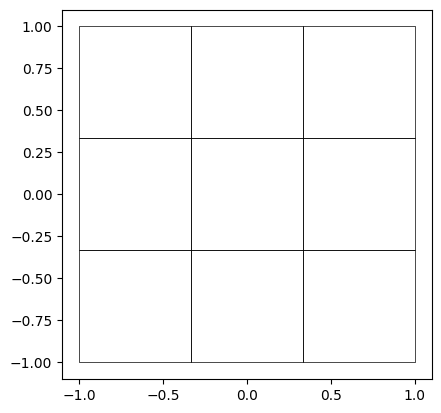

In [62]:
lowerLeft = [-1,-1]
upperRight = [1,1]
elements = [3,3]

grid = dune.grid.structuredGrid(lowerLeft,upperRight,elements)
grid.hierarchicalGrid.globalRefine(0)
grid.plot()

### Add Lagrangian basis

In [63]:
basisLagrange1 = dune.functions.defaultGlobalBasis(grid, dune.functions.Power(dune.functions.Lagrange(order=1),2))
print('We have {} dofs.'.format(len(basisLagrange1)))
print('We have {} vertices.'.format(grid.size(2)))
print('We have {} elements.'.format(grid.size(0)))

We have 32 dofs.
We have 16 vertices.
We have 9 elements.


### Init load factor and displacement vector

In [64]:
d = np.zeros(len(basisLagrange1))
lambdaLoad = iks.ValueWrapper(3.0)

### Define volume load and boundary loads

In [65]:
def volumeLoad(x,lambdaVal) :
    return np.array([lambdaVal*x[0]*2*0, 2*lambdaVal*x[1]*0])

def neumannLoad(x,lambdaVal) :
    return np.array([lambdaVal*10, lambdaVal*10])

neumannVertices = np.zeros(grid.size(2)*2, dtype=bool)
basisLagrange1.interpolate(neumannVertices, lambda x :  True  if x[1]==1 else False)

boundaryPatch = iks.utils.boundaryPatch(grid,neumannVertices)

### Create material

In [66]:
svk = iks.StVenantKirchhoff(emodul=1000,nu=0.3)

svkPS = svk.asPlainStress()

### Create vector of finite elements

In [67]:
fes = []
for e in grid.elements:
    fes.append(iks.finite_elements.nonLinearElasticElement(basisLagrange1,e,svkPS,volumeLoad,boundaryPatch,neumannLoad))

### Create Dirichlet boundary conditions

In [68]:
dirichletValues = iks.dirichletValues(basisLagrange1) 

def fixBottomEdge(vec,localIndex,localView,intersection):
    if (intersection.geometry.center[1]==-1):
        vec[localView.index(localIndex)]= True

dirichletValues.fixBoundaryDOFsUsingLocalViewAndIntersection(fixBottomEdge)

### Create assembler

In [69]:
assembler = iks.assembler.sparseFlatAssembler(fes,dirichletValues)

### Define functions

In [70]:
def energy(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.ScalarAffordances.mechanicalPotentialEnergy)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    return assembler.getScalar(req)

def gradient(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.VectorAffordances.forces)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    return assembler.getReducedVector(req)

def hess(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.MatrixAffordances.stiffness)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    return assembler.getReducedMatrix(req)

def gradAndhess(dRedInput) :
    req = iks.FErequirements()
    req.addAffordance(iks.MatrixAffordances.stiffness)
    req.addAffordance(iks.VectorAffordances.forces)
    req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
    dBig = assembler.createFullVector(dRedInput)
    req.insertGlobalSolution(iks.FESolutions.displacement,dBig)
    g = assembler.getReducedVector(req)
    h = assembler.getReducedMatrix(req)  
    return [g, h]

### Solve using scipy

In [71]:
from numpy.linalg import norm
maxiter = 100
abs_tolerance = 1e-8
d = np.zeros(assembler.reducedSize())
for k in range(maxiter):
    R, K = gradAndhess(d)
    r_norm = norm(R)
    
    deltad = sp.sparse.linalg.spsolve(K, R)
    d -= deltad
    print(k,r_norm,norm(deltad),energy(d))
    if r_norm < abs_tolerance:
        break

print("Energy at equilibrium: ",energy(d))    

0 44.721359549995796 0.9126794029290993 -10.185808977929787
1 42.808747293747295 0.10379940793644327 -11.206285818818346
2 1.6167347204336329 0.012854667382298441 -11.209991304289455
3 0.01642372700744036 7.610851642512454e-05 -11.209991516690044
4 8.403451540291112e-07 5.249989618337343e-09 -11.209991516690042
5 6.389331095285903e-14 7.992142770705221e-17 -11.209991516690046
Energy at equilibrium:  -11.209991516690046


In [72]:
#dRed0 = np.zeros(assembler.reducedSize())

#sp.optimize.show_options("root","hybr")
#from scipy.optimize.nonlin import nonlin_solve
#from scipy.optimize import fsolve
#result = nonlin_solve(gradient,dRed0,hess, line_search=False)
#result = fsolve(gradient,dRed0,fprime=hess)
#print(result)
#result = minimize(energy,x0=dRed0,options={"disp": True},tol=1e-14)
#result = minimize(energy,x0=dRed0,jac=gradient,options={"disp": True})
#result = minimize(energy,method="trust-krylov",x0=dRed0,jac=gradient,hessp=hess,options={ 'disp': True, 'inexact': True})
#result = sp.optimize.root(gradient,jac=hess,x0=dRed0,tol=1e-10)

In [73]:
#print(result)

fullDisp = assembler.createFullVector(d)

dispFunc = basisLagrange1.asFunction(fullDisp)

writer = vtkWriter( grid, "nameTestNonlinear",  pointData   = {( "displacement",(0,1)):dispFunc})

### Plot here using matplot lib

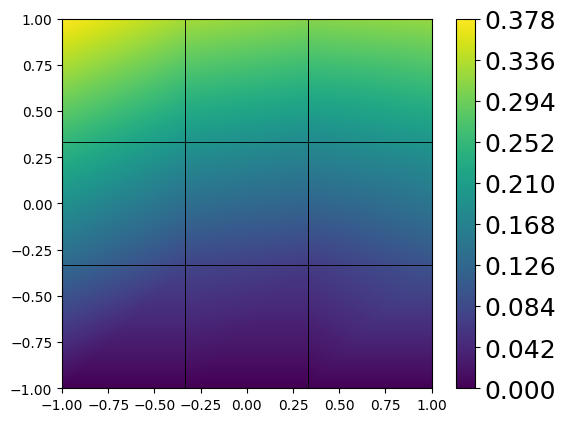

In [75]:
import dune.plotting
dune.plotting.plot(solution=dispFunc,gridLines=None)